# 손실함수(Loss Function)

### Huber Loss

In [645]:
import numpy as np

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [646]:
y_true = np.array([1.0,2.0,3.0,4.0,5.0])
y_pred = np.array([1.2,1.8,3.1,3.9,4.8])

# y_true = np.append(y_true, [50.0,60.0])
# y_pred = np.append(y_pred, [10.0,5.0])

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true,y_pred)

print('mse', mse)
print('mae', mae)

mse 0.028000000000000014
mae 0.16000000000000006


In [647]:
def huber_loss(y_true,y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error**2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

huber_loss(y_true,y_pred)

0.014000000000000007

In [648]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X,y = make_classification(
    n_samples = 1000,
    n_features = 20,
    n_informative=15,
    n_redundant = 5,
    n_classes = 2,
    random_state = 42
)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

def one_hot(labels, num_classes):
    return np.eye(num_classes)[labels]

y_train_oh = one_hot(y_train, 2)
y_test_oh = one_hot(y_test,2)

In [649]:
# 모델 파라미터 초기화
np.random.seed(42)
input_dim = X_train.shape[1]
hidden_dim = 32
output_dim = 2

W1 = np.random.randn(input_dim, hidden_dim)
b1 = np.zeros((1, hidden_dim))
W2 = np.random.randn(hidden_dim, output_dim)
b2 = np.zeros((1, output_dim))

In [650]:
# 활성화 함수, 손실함수 정의
def relu(z):
    return np.maximum(0,z)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(probs,labels):
    m = labels.shape[0]
    log_likelihood = -np.log(probs + 1e-8) * labels
    loss = np.sum(log_likelihood) / m
    return loss

In [651]:
# 학습
learning_rate = 0.01
epochs = 50
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Forward
    Z1 = np.dot(X_train, W1) + b1
    R1 = relu(Z1)   # (hidden_dim, output_dim)                   
    Z2 = np.dot(R1, W2) + b2
    probs = softmax(Z2)
    loss = cross_entropy_loss(probs, y_train_oh)        # 손실 함수가 맨 마지막에 위치 하는 것은? 모델 평가 하기 위해 softmax 함수와 같이 사용

    # Backpropagation
    m = X_train.shape[0]
    dZ2 = (probs - y_train_oh) / m # (N, output_dim)
    dW2 = np.dot(R1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dR1 = np.dot(dZ2, W2.T)
    dZ1 = dR1 * (Z1 > 0)
    dW1 = np.dot(X_train.T, dZ1)    # 변화값
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    # 파라미터 업데이트
    W1 -= learning_rate * dW1   # 손실이 최저점을 찾기 위해 이동하는 것   
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    train_losses.append(loss)
    # 테스트 데이터로 손실 확인
    Z1_test = np.dot(X_test, W1) + b1
    R1_test = relu(Z1_test)   # (hidden_dim, output_dim)                   
    Z2_test = np.dot(R1_test, W2) + b2
    probs_test = softmax(Z2_test)
    loss_test = cross_entropy_loss(probs_test, y_test_oh)
    test_losses.append(loss_test)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1} | 학습 손실: {loss:.4f}, 평가 손실: {loss_test:.4f}")

Epoch 10 | 학습 손실: 4.4511, 평가 손실: 4.4685
Epoch 20 | 학습 손실: 4.0039, 평가 손실: 4.0507
Epoch 30 | 학습 손실: 3.6635, 평가 손실: 3.7196
Epoch 40 | 학습 손실: 3.3840, 평가 손실: 3.4576
Epoch 50 | 학습 손실: 3.1472, 평가 손실: 3.2343


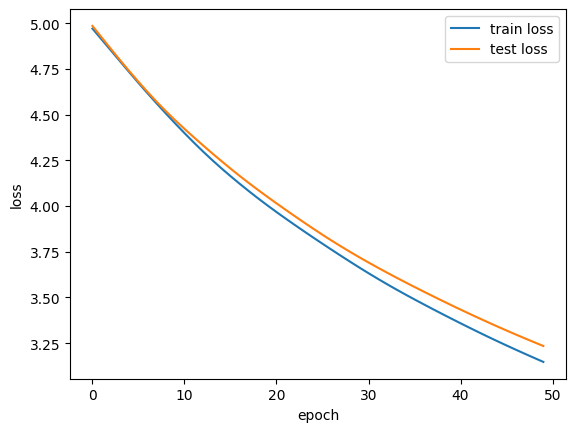

In [652]:
plt.plot(range(epochs), train_losses, label='train loss')
plt.plot(range(epochs), test_losses, label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### 기본 손실함수 vs 커스텀 손실함수

In [653]:
from sklearn.datasets import make_regression

X,y = make_regression(
    n_samples=1000,
    n_features=10,
    noise=50,
    random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1,1)).flatten()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [654]:
# 예측 함수
def predict(X,w,b):
    return np.dot(X,w) + b

In [655]:
# 손실 함수
def mse_loss(y_pred,y_true):
    return np.mean((y_pred - y_true) ** 2)

def my_loss(y_pred,y_true, w, lambda_reg=1.0):
    mse = mse_loss(y_pred,y_true)
    l2_reg = np.sum(w**2)
    return mse + (lambda_reg * l2_reg)

In [656]:
# 손실 함수
def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2)

def my_loss(y_pred, y_true, W, lambda_reg=1.0):
    mse = mse_loss(y_pred, y_true)
    l2_reg = np.sum(W ** 2)     # L2 규제는 제곱합을 더해주는 것 
    return mse + (lambda_reg * l2_reg)

def train_model(X_train, y_train, X_test, y_test, loss_fn, epochs=100, learning_rate=0.1, use_custom=False):
    np.random.seed(42)
    n_features = X_train.shape[1]
    W = np.random.randn(n_features)
    b = 0.0

    for epoch in range(epochs):
        y_pred_train = predict(X_train, W, b)
        y_pred_test = predict(X_test, W, b)

        train_loss = loss_fn(y_pred_train, y_train, W) if use_custom else loss_fn(y_pred_train, y_train)
        test_loss = loss_fn(y_pred_test, y_test, W) if use_custom else loss_fn(y_pred_test, y_test)

        d_loss = 2 * (y_pred_train - y_train) / X_train.shape[0]
        grad_w = np.dot(X_train.T, d_loss)
        grad_b = np.sum(d_loss)

        if use_custom:
            grad_w += 2 * 1.0 * W   # l.0은 lambda_reg=1.0로 같은 값을 규제하기 위함

        W -= learning_rate * grad_w
        b -= learning_rate * grad_b

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1} | 학습 손실: {train_loss:.4f}, 테스트 손실: {test_loss:.4f}")

In [657]:
train_model(X_train,y_train, X_test, y_test, mse_loss)

Epoch 10 | 학습 손실: 0.1782, 테스트 손실: 0.1833
Epoch 20 | 학습 손실: 0.1216, 테스트 손실: 0.1255
Epoch 30 | 학습 손실: 0.1209, 테스트 손실: 0.1242
Epoch 40 | 학습 손실: 0.1209, 테스트 손실: 0.1241
Epoch 50 | 학습 손실: 0.1209, 테스트 손실: 0.1241
Epoch 60 | 학습 손실: 0.1209, 테스트 손실: 0.1241
Epoch 70 | 학습 손실: 0.1209, 테스트 손실: 0.1241
Epoch 80 | 학습 손실: 0.1209, 테스트 손실: 0.1241
Epoch 90 | 학습 손실: 0.1209, 테스트 손실: 0.1241
Epoch 100 | 학습 손실: 0.1209, 테스트 손실: 0.1241


In [658]:
train_model(X_train,y_train,X_test,y_test, my_loss, use_custom=True)

Epoch 10 | 학습 손실: 0.5709, 테스트 손실: 0.5544
Epoch 20 | 학습 손실: 0.5698, 테스트 손실: 0.5548
Epoch 30 | 학습 손실: 0.5698, 테스트 손실: 0.5550
Epoch 40 | 학습 손실: 0.5698, 테스트 손실: 0.5550
Epoch 50 | 학습 손실: 0.5698, 테스트 손실: 0.5550
Epoch 60 | 학습 손실: 0.5698, 테스트 손실: 0.5550
Epoch 70 | 학습 손실: 0.5698, 테스트 손실: 0.5550
Epoch 80 | 학습 손실: 0.5698, 테스트 손실: 0.5550
Epoch 90 | 학습 손실: 0.5698, 테스트 손실: 0.5550
Epoch 100 | 학습 손실: 0.5698, 테스트 손실: 0.5550


### 손실 함수 선택이 모델 성능에 미치는 영향

In [659]:
make_regression(
    n_samples=1000,
    n_features=5,
    noise=30,
    random_state=42
)

scaler_X = StandardScaler()
sclaer_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1,1)).flatten()

X_train,X_test, y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)


In [660]:
# 선형 회귀 모델 예측 함수
def predict(X,W,b):
    return np.dot(X,W) + b

In [661]:
# 손실 함수
def mse_loss(y_pred,y_true):
    return np.mean((y_pred - y_true) **2)

def mae_loss(y_pred,y_true):
    return np.mean(np.abs(y_pred,y_true))

def huber_loss(y_pred,y_true, delta=1.0):
    error = y_pred - y_true
    is_small_error = np.abs(error) <= delta
    squared_error = 0.5 * error**2
    linear_error = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_error, linear_error))

In [662]:
def train_regression(X,y,loss_fn,epochs=100, learning_rate=0.01):
    n_features = X.shape[1]
    W = np.random.randn(n_features)
    b = 0.0
    m = X.shape[0]
    epsilon = 1e-5   #1*10^(-5)
    losses=[]
    
    for epoch in range(epochs):
        y_pred = predict(X,W,b)
        loss = loss_fn(y_pred, y)
        losses.append(loss)
        grad_w = np.zeros_like(W)
        for i in range(len(W)):
            W_eps = np.copy(W)
            W_eps[i] += epsilon
            loss_eps = loss_fn(predict(X,W_eps,b),y)
            grad_w[i] = (loss_eps - loss) / epsilon
            
        b_eps = b+ epsilon
        loss_eps_b = loss_fn(predict(X,W_eps,b),y)
        grad_b = (loss_eps_b - loss) / epsilon
        
        W -= learning_rate * grad_w
        b -= learning_rate * grad_b
        
    return W,b,losses

In [663]:
results = {}

for name, loss_fn in zip(['MSE', 'MAE', 'Huber'],[mse_loss, mae_loss, huber_loss]):
    W,b ,losses= train_regression(X_test, y_test, loss_fn)
    results[name] = {'losses' : losses}
    pred_test = predict(X_test, W,b)
    test_loss = mse_loss(pred_test,y_test)
    print(f'{name} Loss :{test_loss:.4f}')

MSE Loss :2.6489
MAE Loss :5.9347
Huber Loss :11.4388


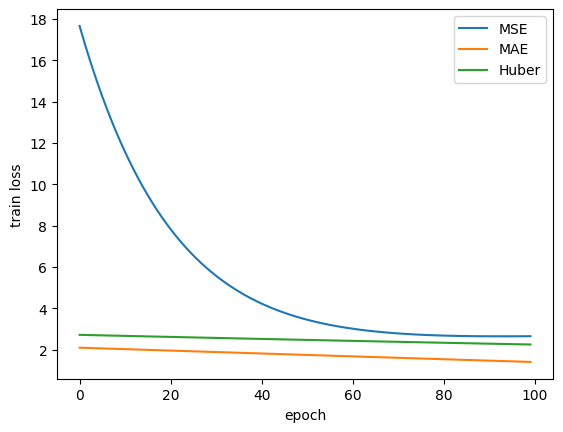

In [664]:
for name, value in results.ite0ms():
    plt.plot(value['losses'], label=name)
    
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.legend()
plt.show()